__May 4th 2020 (BP)__: Constraining the trace norm of the phi = W @ x matrix  

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import LinearSVC
import numpy as np
import numpy.linalg as la
import scipy
from estimator import RFClassifier, relu

In [5]:
# tests to check the estimator.py
from data_fns import pure_sine_dft
from sklearn.model_selection import train_test_split

X, y = pure_sine_dft(nPoints=5000, fs=1500, sig_dur=0.1, k=6, a=0.7)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [6]:
clf = RFClassifier(width=20, weights='white noise', weight_fun=None, nonlinearity=relu)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.578

Generate bandpass weights using the dft matrix.

In [7]:
import matplotlib.pyplot as plt

In [8]:
X, y = pure_sine_dft(nPoints=5000, fs=1500, sig_dur=0.1, k=6, a=0.95)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

M, N = 20, X.shape[1]

In [118]:
dft = scipy.linalg.dft(N, scale=None)

lowcut, highcut = 1, 20
rand = np.zeros((M, N))
rand[:, lowcut:highcut] = np.random.normal(size=(M, highcut-lowcut))
W = (rand @ dft).real.T
W /= np.std(W, axis=0)

In [372]:
def bp_gaus_weights_dft(M, N, lowcut, highcut):
    dft = scipy.linalg.dft(N, scale=None)
    rand = np.zeros((M, N), dtype=complex)
    phi = np.random.uniform(-np.pi, np.pi, (M, highcut - lowcut))
    rand[:, lowcut:highcut] = np.random.normal(size=(M, highcut-lowcut)).astype(complex) * np.e ** (1j * phi)
#     rand[:, lowcut:highcut] = np.random.normal(size=(M, highcut-lowcut))
    W = (rand @ dft).real.T
    W /= np.std(W, axis=0)
    return W

def white_noise_weights_dft(M, N):
    dft = scipy.linalg.dft(N, scale=None)
    rand = np.random.normal(size=(M, N))
    W = (rand @ dft).real.T
    W /= np.std(W, axis=0)
    return W

In [373]:
wt  = bp_gaus_weights_dft(M, N, 5, 8)
print(la.norm(wt, axis=0))

wn_wt = white_noise_weights_dft(M, N)
print(la.norm(wn_wt, axis=0))

[12.24744871 12.24744871 12.24744871 12.24744871 12.24744871 12.24744871
 12.24744871 12.24744871 12.24744871 12.24744871 12.24744871 12.24744871
 12.24744871 12.24744871 12.24744871 12.24744871 12.24744871 12.24744871
 12.24744871 12.24744871]
[12.4137765  12.44640439 12.25216735 12.29956162 12.25435233 12.30172445
 12.34044058 12.39572873 12.43799384 12.24779671 12.70464562 12.55054628
 12.32639754 12.25094011 12.30314842 12.35995484 12.27286729 12.42534484
 12.39867238 12.32077114]


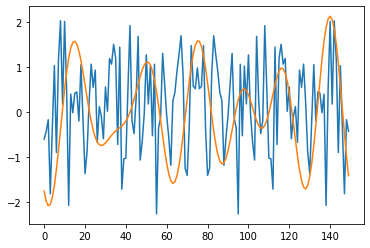

In [374]:
fig = plt.figure()
plt.plot(wn_wt[:, 0])
plt.plot(wt[:,18])

(150, 20)